In [ ]:
#load the libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm.auto import tqdm


In [ ]:
# Import MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_data = torchvision.datasets.FashionMNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 14801617.42it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 257146.89it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5086998.78it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20583676.83it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_data, val_data = torch.utils.data.random_split(train_dataset, [50000, 10000], torch.Generator().manual_seed(9))

In [ ]:
# Data loader
train_loader = DataLoader(dataset= train_data,batch_size= 64,shuffle=True)
val_loader = DataLoader(dataset= val_data,batch_size= 64,shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size= 64,shuffle= False)

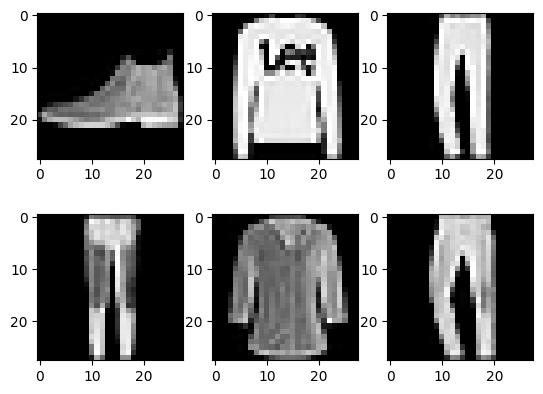

In [ ]:
examples = next(iter(test_loader))
example_data, example_targets = examples
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [ ]:
# Fully connected neural network with one hidden layer
class MNISTNET(nn.Module):
    def __init__(self):
        super(MNISTNET, self).__init__()
        self.l1 = nn.Linear(28*28, 1024)
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, 128)
        self.l4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        x = F.softmax(x, dim=1)

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = MNISTNET().to(device)
model

MNISTNET(
  (l1): Linear(in_features=784, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=128, bias=True)
  (l4): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
EPOCHS = 25
learning_rate = 1e-3

In [ ]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import accuracy_score

def train_model(model, dataloader, optmizer, loss_fn):
    model.train()
    train_loss, train_acc= 0, 0

    for X, y in dataloader:
        # Forward Pass
        X, y = X.reshape(-1, 28*28).to(torch.device(device)), y.to(torch.device(device))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

        # Back Propagation
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        train_loss /= len(dataloader)

    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")

    return train_loss, train_acc

In [ ]:
def val_model(model, dataloader, optmizer, loss_fn):
  model.eval()
  val_loss, val_acc= 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.reshape(-1, 28*28).to(device), y.to(device)
      y_pred = model(X)

      val_loss += loss_fn(y_pred, y)
      val_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

      val_loss /= len(dataloader)

  val_acc /= len(dataloader)
  print(f"Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")

  return val_loss, val_acc

In [ ]:
torch.manual_seed(0)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in tqdm(range(EPOCHS)):

  print(f"Epoch {epoch + 1}/{EPOCHS}")

  x1 = train_model(model, train_loader, optimizer, loss_fn)
  train_loss.append(x1[0])
  train_acc.append(x1[1])
  x2 = val_model(model, val_loader, optimizer, loss_fn)
  val_loss.append(x2[0])
  val_acc.append(x2[1])

  print("--------------------------------------------------------")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25
Train loss: 0.0023 | Train accuracy: 0.6976
Val loss: 0.0113 | Val accuracy: 0.7209
--------------------------------------------------------
Epoch 2/25
Train loss: 0.0020 | Train accuracy: 0.7178
Val loss: 0.0122 | Val accuracy: 0.7354
--------------------------------------------------------
Epoch 3/25
Train loss: 0.0024 | Train accuracy: 0.7290
Val loss: 0.0114 | Val accuracy: 0.7245
--------------------------------------------------------
Epoch 4/25
Train loss: 0.0023 | Train accuracy: 0.7282
Val loss: 0.0118 | Val accuracy: 0.7560
--------------------------------------------------------
Epoch 5/25
Train loss: 0.0022 | Train accuracy: 0.7430
Val loss: 0.0102 | Val accuracy: 0.7721
--------------------------------------------------------
Epoch 6/25
Train loss: 0.0022 | Train accuracy: 0.7805
Val loss: 0.0106 | Val accuracy: 0.7894
--------------------------------------------------------
Epoch 7/25
Train loss: 0.0023 | Train accuracy: 0.7906
Val loss: 0.0118 | Val accuracy: 

In [ ]:
train_loss_np = [item.detach().cpu().numpy() for item in train_loss]
train_acc_np = [item for item in train_acc]
val_loss_np = [item.detach().cpu().numpy() for item in val_loss]
val_acc_np = [item for item in val_acc]


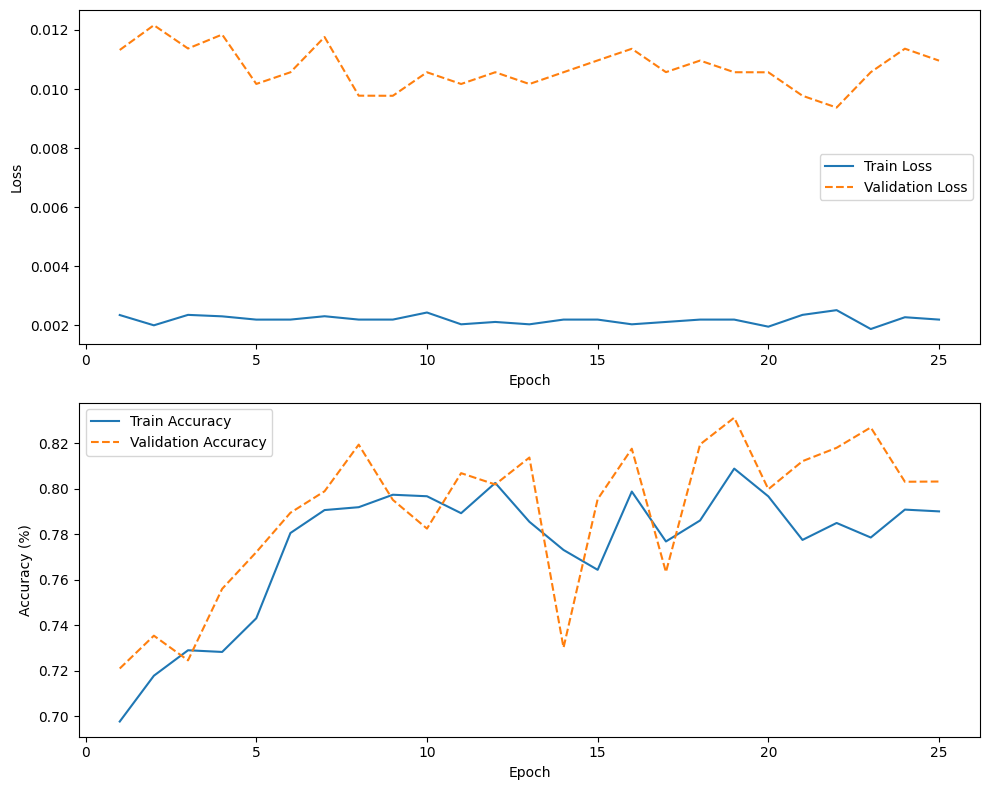

In [ ]:
# Plotting the loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(range(1, EPOCHS+1), train_loss_np, label='Train Loss')
ax1.plot(range(1, EPOCHS+1), val_loss_np, label='Validation Loss', linestyle='dashed')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, EPOCHS+1), train_acc_np, label='Train Accuracy')
ax2.plot(range(1, EPOCHS+1), val_acc_np, label='Validation Accuracy', linestyle='dashed')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
def test_model(model, dataloader, optmizer, loss_fn):
  model.eval()
  test_loss, test_acc= 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.reshape(-1, 28*28).to(device), y.to(device)
      y_pred = model(X)

      test_loss += loss_fn(y_pred, y)
      test_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

      test_loss /= len(dataloader)

  test_acc /= len(dataloader)
  print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

  return

In [ ]:
test_model(model, test_loader, optimizer, loss_fn)

Test loss: 0.0106 | Test accuracy: 0.7952
